<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
# Necessário para o modelo Transformer
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 7

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 256
NUCLEO_CONV = 5
NUCLEO_SAIDA = 32
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3
ITERACOES_MLP = 20

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

### Converter texto em números

In [12]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [13]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [14]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [15]:
vetorizador.adapt(X)

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=256,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

## Funções

In [19]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelos_nome[modelo_numero])

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, matriz=True, rotulos=None, cmap='summer_r'):
    if(matriz):
        print(classification_report(validacao, previsao, target_names=rotulos))

        ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, cmap=cmap)
        plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acurácia': relatorio['accuracy'],
            'precisão': relatorio['weighted avg']['precision'],
            'revocação': relatorio['weighted avg']['recall'],
            'pontuação-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice, X_val=X_val):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

def teste_modelo(indice, X_test=X_test):
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice], False)

## Modelos

In [20]:
modelos_nome = [None] * MAXIMO_MODELOS

modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [21]:
%%time

modelo_numero = 0

modelos_nome[modelo_numero] = 'TF-IDF'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

CPU times: user 2.71 s, sys: 39 ms, total: 2.75 s
Wall time: 3.26 s


Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



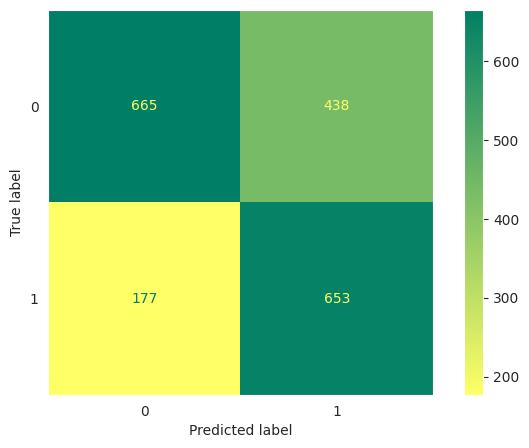

In [23]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [24]:
relatorios[modelo_numero]

{'acurácia': 0.6818416968442835,
 'precisão': 0.7076652728288632,
 'revocação': 0.6818416968442835,
 'pontuação-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [25]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 77.2 ms, sys: 3.21 ms, total: 80.4 ms
Wall time: 181 ms


### Modelo 1: MLP

In [26]:
%%time

modelo_numero = 1

modelos_nome[modelo_numero] = 'MLP'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES_MLP,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/20
242/242 [==============================] - 68s 258ms/step - loss: 0.6304 - accuracy: 0.7392 - val_loss: 0.5553 - val_accuracy: 0.8546
Epoch 2/20
242/242 [==============================] - 49s 204ms/step - loss: 0.4631 - accuracy: 0.8727 - val_loss: 0.4020 - val_accuracy: 0.8733
Epoch 3/20
242/242 [==============================] - 45s 187ms/step - loss: 0.3276 - accuracy: 0.8822 - val_loss: 0.3223 - val_accuracy: 0.8733
Epoch 4/20
242/242 [==============================] - 40s 167ms/step - loss: 0.2429 - accuracy: 0.9039 - val_loss: 0.2771 - val_accuracy: 0.8883
Epoch 5/20
242/242 [==============================] - 39s 161ms/step - loss: 0.1810 - accuracy: 0.9426 - val_loss: 0.2489 - val_accuracy: 0.8971
Epoch 6/20
242/242 [==============================] - 35s 146ms/step - loss: 0.1361 - accuracy: 0.9649 - val_loss: 0.2307 - val_accuracy: 0.9027
Epoch 7/20
242/242 [==============================] - 28s 118ms/step - loss: 0.1036 - accuracy: 0.9776 - val_loss: 0.2190 - val_ac

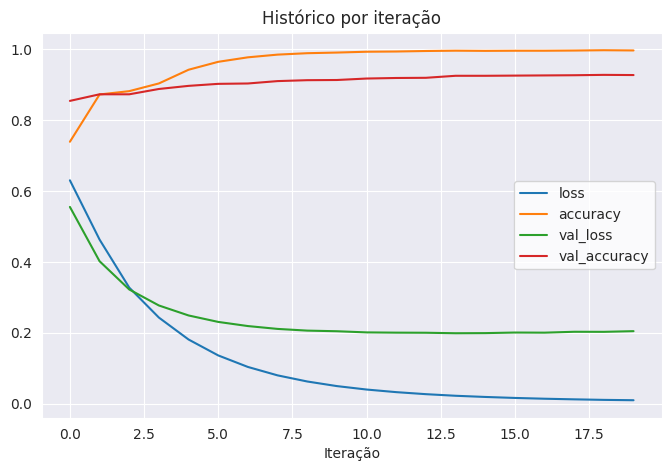

In [27]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1103
           1       0.95      0.88      0.91       830

    accuracy                           0.93      1933
   macro avg       0.93      0.92      0.93      1933
weighted avg       0.93      0.93      0.93      1933



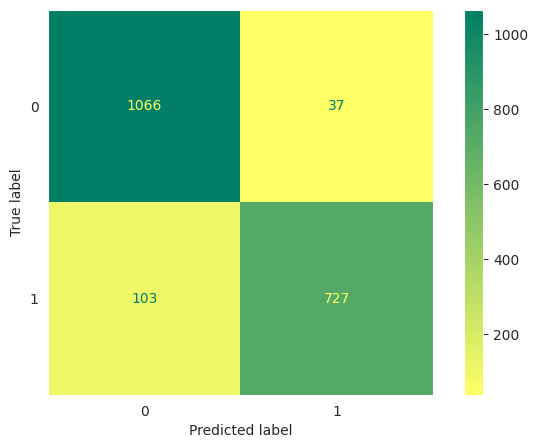

In [28]:
dados_modelo(modelo_numero)

In [29]:
relatorios[modelo_numero]

{'acurácia': 0.9275737196068288,
 'precisão': 0.9289285523077827,
 'revocação': 0.9275737196068288,
 'pontuação-f1': 0.9271262709885737}

### Modelo 2: CNN

In [30]:
%%time

modelo_numero = 2

modelos_nome[modelo_numero] = 'RNC'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 49s 189ms/step - loss: 0.3234 - accuracy: 0.8832 - val_loss: 0.2584 - val_accuracy: 0.8955
Epoch 2/3
242/242 [==============================] - 42s 174ms/step - loss: 0.0749 - accuracy: 0.9759 - val_loss: 0.2616 - val_accuracy: 0.9048
Epoch 3/3
242/242 [==============================] - 38s 157ms/step - loss: 0.0170 - accuracy: 0.9964 - val_loss: 0.3088 - val_accuracy: 0.8960
CPU times: user 1min 52s, sys: 2.51 s, total: 1min 54s
Wall time: 2min 23s


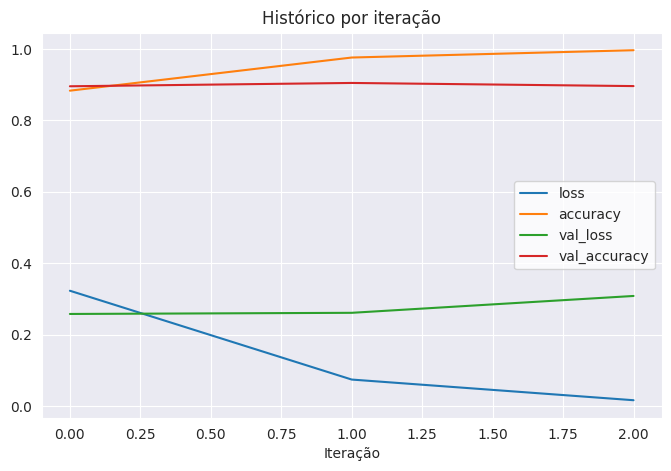

In [31]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1103
           1       0.86      0.91      0.88       830

    accuracy                           0.90      1933
   macro avg       0.89      0.90      0.89      1933
weighted avg       0.90      0.90      0.90      1933



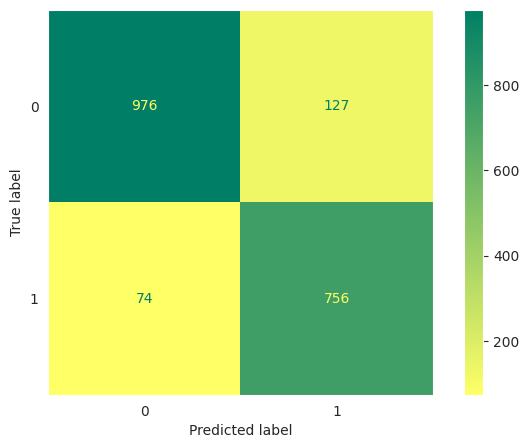

In [32]:
dados_modelo(modelo_numero)

In [33]:
relatorios[modelo_numero]

{'acurácia': 0.8960165545783756,
 'precisão': 0.8980277488163234,
 'revocação': 0.8960165545783756,
 'pontuação-f1': 0.8963453012473459}

### Modelo 3: DCNN

In [34]:
%%time

modelo_numero = 3

modelos_nome[modelo_numero] = 'CFN-AI'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 53s 207ms/step - loss: 0.0723 - accuracy: 0.9712 - val_loss: 0.4301 - val_accuracy: 0.8888
Epoch 2/3
242/242 [==============================] - 45s 186ms/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 0.4407 - val_accuracy: 0.8883
Epoch 3/3
242/242 [==============================] - 45s 187ms/step - loss: 0.0057 - accuracy: 0.9969 - val_loss: 0.4805 - val_accuracy: 0.8846
CPU times: user 2min, sys: 2.65 s, total: 2min 2s
Wall time: 3min 23s


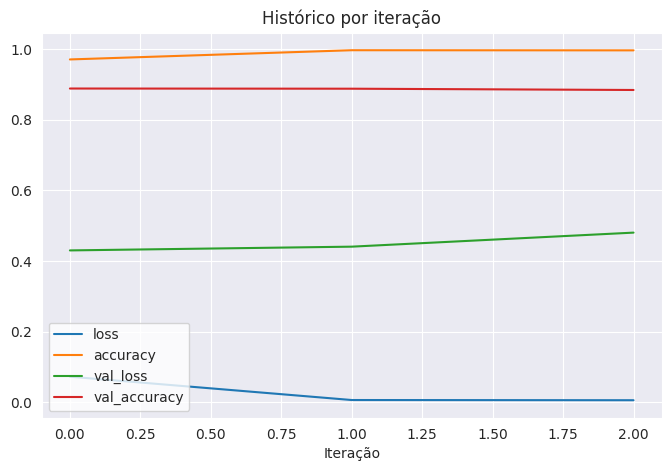

In [35]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1103
           1       0.86      0.87      0.87       830

    accuracy                           0.88      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.88      0.88      0.88      1933



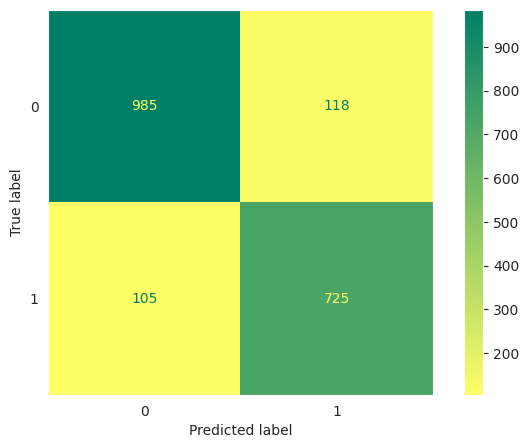

In [36]:
dados_modelo(modelo_numero)

In [37]:
relatorios[modelo_numero]

{'acurácia': 0.8846352819451629,
 'precisão': 0.8849288142781775,
 'revocação': 0.8846352819451629,
 'pontuação-f1': 0.8847415628239318}

### Modelo 4: RNN (LSTM Bidirecional)

In [38]:
%%time

modelo_numero = 4

modelos_nome[modelo_numero] = 'RNR'

camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA * 2,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 63s 477ms/step - loss: 0.2989 - accuracy: 0.8675 - val_loss: 0.2692 - val_accuracy: 0.8950
Epoch 2/3
121/121 [==============================] - 53s 437ms/step - loss: 0.1040 - accuracy: 0.9662 - val_loss: 0.4151 - val_accuracy: 0.8888
Epoch 3/3
121/121 [==============================] - 51s 425ms/step - loss: 0.0353 - accuracy: 0.9903 - val_loss: 0.5127 - val_accuracy: 0.8965
CPU times: user 2min 4s, sys: 19.1 s, total: 2min 23s
Wall time: 3min 27s


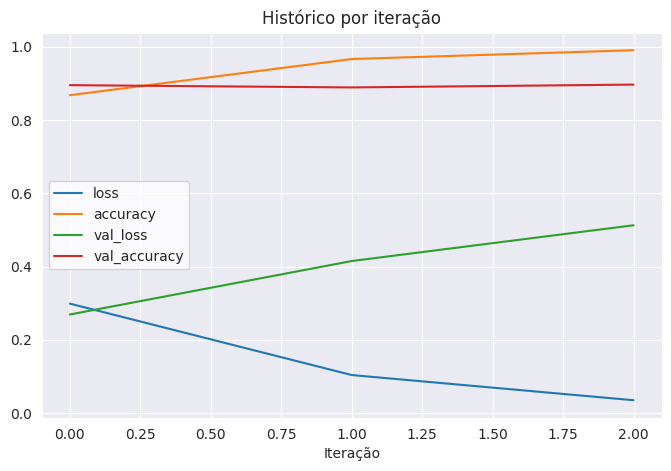

In [39]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 5s 64ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1103
           1       0.88      0.88      0.88       830

    accuracy                           0.90      1933
   macro avg       0.89      0.89      0.89      1933
weighted avg       0.90      0.90      0.90      1933



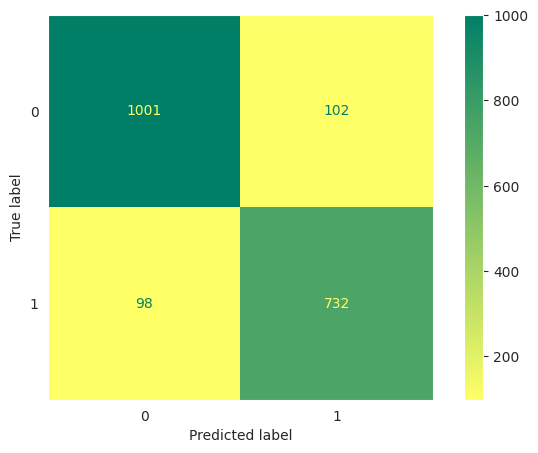

In [40]:
dados_modelo(modelo_numero)

In [41]:
relatorios[modelo_numero]

{'acurácia': 0.8965338851526126,
 'precisão': 0.8966024421805506,
 'revocação': 0.8965338851526126,
 'pontuação-f1': 0.8965642687908413}

### Modelo 5: Transformer

In [42]:
%%time

modelo_numero = 5

modelos_nome[modelo_numero] = 'Transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 93s 320ms/step - loss: 0.5995 - accuracy: 0.6748 - val_loss: 0.5173 - val_accuracy: 0.7444
Epoch 2/3
242/242 [==============================] - 55s 228ms/step - loss: 0.4490 - accuracy: 0.7858 - val_loss: 0.4719 - val_accuracy: 0.7651
Epoch 3/3
242/242 [==============================] - 51s 213ms/step - loss: 0.3721 - accuracy: 0.8330 - val_loss: 0.4573 - val_accuracy: 0.7843
CPU times: user 3min 17s, sys: 13.4 s, total: 3min 30s
Wall time: 3min 36s


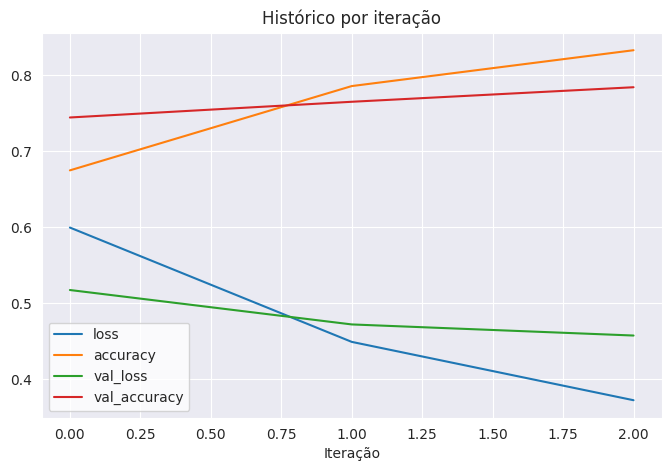

In [43]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 8s 126ms/step
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1103
           1       0.84      0.61      0.71       830

    accuracy                           0.78      1933
   macro avg       0.80      0.76      0.77      1933
weighted avg       0.79      0.78      0.78      1933



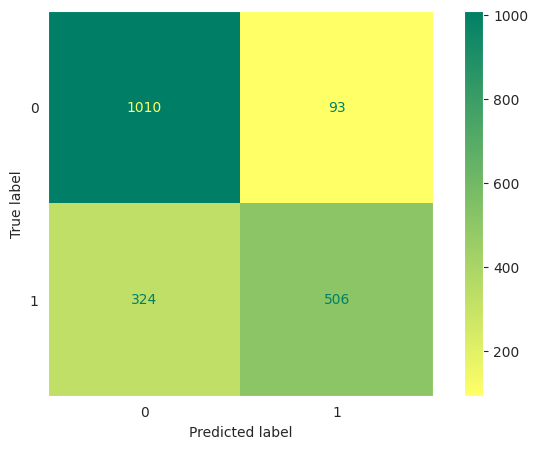

In [44]:
dados_modelo(modelo_numero)

In [45]:
relatorios[modelo_numero]

{'acurácia': 0.7842731505431971,
 'precisão': 0.7947440108131728,
 'revocação': 0.7842731505431971,
 'pontuação-f1': 0.7770610967178958}

### Modelo 6: fakeDETECTOR

In [46]:
%%time

modelo_numero = 6

modelos_nome[modelo_numero] = 'fakeD'

train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

modelos[modelo_numero] = Sequential()

modelos[modelo_numero].add(Embedding((len(tokenizer.word_index) + 1), 200, input_length=max_sequence_length))

modelos[modelo_numero].add(Conv1D(ESPACO_SAIDA, NUCLEO_CONV, activation=ATIVACAO_CNN))

modelos[modelo_numero].add(GlobalMaxPool1D())

modelos[modelo_numero].add(Dense(ESPACO_SAIDA, activation=ATIVACAO_CNN))

modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=train_sequences,
                                                       y=y_train,
                                                       epochs=ITERACOES,
                                                       batch_size=NUCLEO_SAIDA,
                                                       validation_data=(val_sequences, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 62s 247ms/step - loss: 0.3569 - accuracy: 0.8471 - val_loss: 0.2367 - val_accuracy: 0.8965
Epoch 2/3
242/242 [==============================] - 53s 221ms/step - loss: 0.0803 - accuracy: 0.9710 - val_loss: 0.2403 - val_accuracy: 0.9136
Epoch 3/3
242/242 [==============================] - 46s 191ms/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.2537 - val_accuracy: 0.9167
CPU times: user 1min 55s, sys: 2.22 s, total: 1min 57s
Wall time: 2min 44s


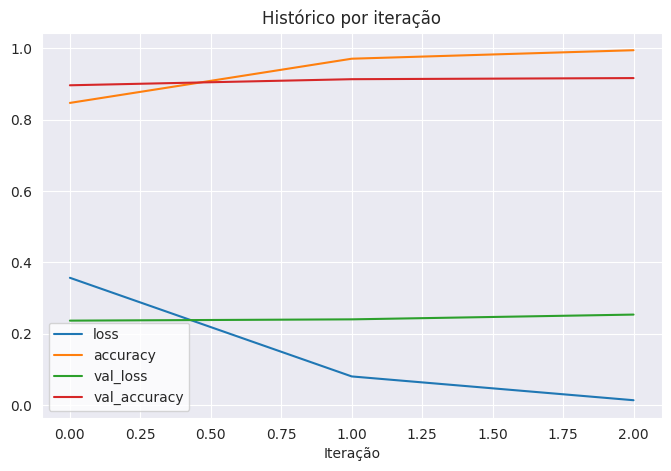

In [47]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1103
           1       0.93      0.87      0.90       830

    accuracy                           0.92      1933
   macro avg       0.92      0.91      0.91      1933
weighted avg       0.92      0.92      0.92      1933



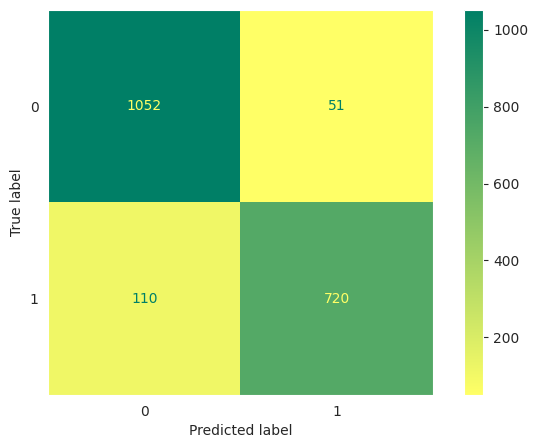

In [48]:
dados_modelo(modelo_numero, val_sequences)

In [49]:
relatorios[modelo_numero]

{'acurácia': 0.9167097775478531,
 'precisão': 0.9175801728914572,
 'revocação': 0.9167097775478531,
 'pontuação-f1': 0.9162598686533314}

## Comparar modelos

In [50]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

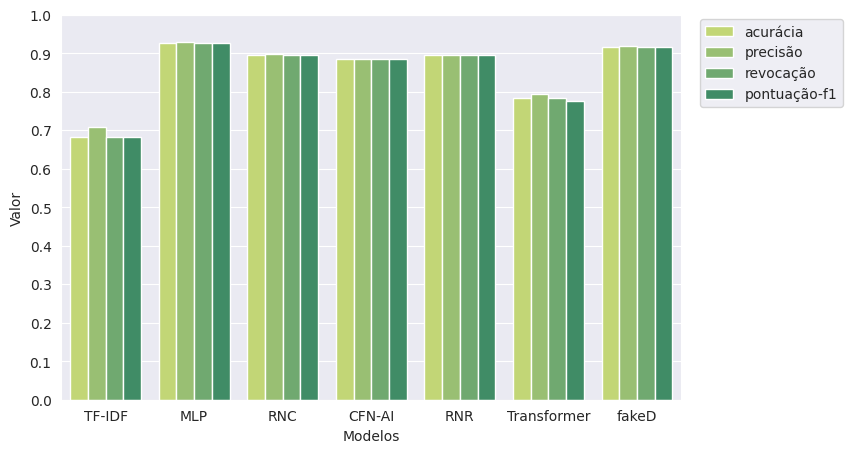

In [51]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de validação')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));

## Teste modelos

In [52]:
for modelo_numero, modelo in enumerate(modelos):
    teste_modelo(modelo_numero, (test_sequences if modelo_numero == 6 else X_test))
    print(modelos_nome[modelo_numero] + ": ")
    print(relatorios[modelo_numero])

TF-IDF: 
{'acurácia': 0.6945996275605214, 'precisão': 0.7166911431006447, 'revocação': 0.6945996275605214, 'pontuação-f1': 0.6953571740701041}
34/34 [==============================] - 0s 4ms/step
MLP: 
{'acurácia': 0.9171322160148976, 'precisão': 0.9170916451209323, 'revocação': 0.9171322160148976, 'pontuação-f1': 0.9169743902756546}
34/34 [==============================] - 0s 13ms/step
RNC: 
{'acurácia': 0.8249534450651769, 'precisão': 0.8414216126476792, 'revocação': 0.8249534450651769, 'pontuação-f1': 0.8257290802045435}
34/34 [==============================] - 1s 29ms/step
CFN-AI: 
{'acurácia': 0.8445065176908753, 'precisão': 0.8514571275814606, 'revocação': 0.8445065176908753, 'pontuação-f1': 0.8452602271641945}
34/34 [==============================] - 2s 64ms/step
RNR: 
{'acurácia': 0.8817504655493482, 'precisão': 0.8815727598403352, 'revocação': 0.8817504655493482, 'pontuação-f1': 0.8815985052676599}
34/34 [==============================] - 6s 161ms/step
Transformer: 
{'acurácia

In [53]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

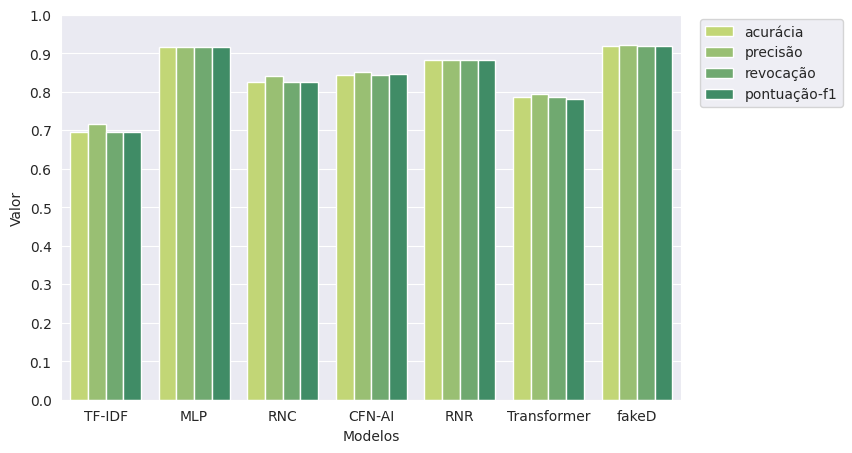

In [54]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de teste')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));